# Loan Approval Prediction.

## Overview

**Loan approval prediction as a classification problem involves categorizing loan applications into either "Approved" or "Rejected." This is achieved by analyzing features such as credit score, income, employment status, loan amount, and more.**

**Goal**: 
The goal for this competition is to predict whether an applicant is approved for a loan.

**Evaluation**
Submissions are evaluated using area under the ROC curve using the predicted probabilities and the ground truth targets.

# Import

In [1]:
# importing libraries.
import pandas as pd
import numpy as np

# import the visualization tools
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px

# modelling tools.
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
import optuna
import warnings
warnings.simplefilter("ignore")

In [2]:
# Creating a function that preprocess the data.
def wrangle(filepath):
    # Read the csv file.
    df = pd.read_csv(filepath, index_col= "id")

    return df

In [3]:
filepath = "/kaggle/input/playground-series-s4e10/train.csv"
df = wrangle(filepath)
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [4]:
# Checking the shape of the data.
df.shape

(58645, 12)

In [5]:
df.nunique()

person_age                      53
person_income                 2641
person_home_ownership            4
person_emp_length               36
loan_intent                      6
loan_grade                       7
loan_amnt                      545
loan_int_rate                  362
loan_percent_income             61
cb_person_default_on_file        2
cb_person_cred_hist_length      29
loan_status                      2
dtype: int64

In [6]:
df.describe() # Getting the aggregate of the data.

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


In [8]:
# Checking if there is any column with null values.
df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

Perfect the Data is clean.

## EDA(Exploratory Data Analysis)

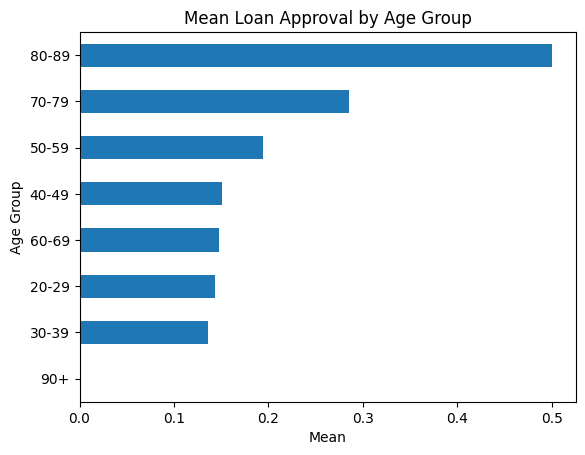

In [9]:
# Creating age group.
df_analysis = df.copy()
bins = [20, 30, 40, 50, 60, 70, 80, 90, 130]
age_class = ["20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89", "90+"]
df_analysis["age_group"] =pd.cut(df_analysis["person_age"], bins=bins, labels=age_class, right=False)
df_analysis.groupby(["age_group"])["loan_status"].mean().sort_values().plot(kind="barh")
plt.title("Mean Loan Approval by Age Group")
plt.ylabel("Age Group")
plt.xlabel("Mean");

Here is a very insightful display showing that people below the age group of 20-49 has very low probability of getting loan.
The age group of 90+ has very low probability of getting loan this can be because of the limited number of data for this age group.

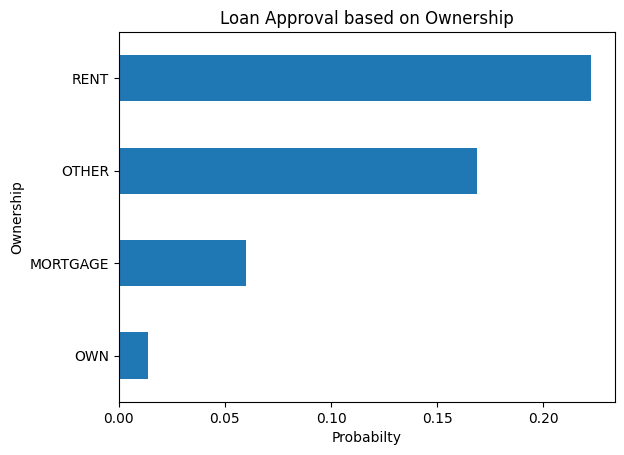

In [10]:
df_analysis.groupby(["person_home_ownership"])["loan_status"].mean().sort_values().plot(kind="barh")
plt.title("Loan Approval based on Ownership")
plt.xlabel("Probabilty")
plt.ylabel("Ownership");

Based on the Visualization above, it can be seen that people who rent a house are likely to get more loan in comparism with someone who own a house.

So this data is likely to be a Home/Rent Loan dataset.

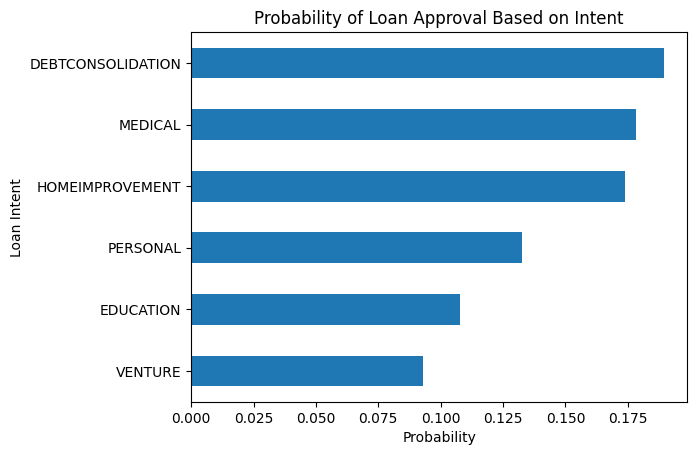

In [11]:
df_analysis.groupby(["loan_intent"])["loan_status"].mean().sort_values().plot(kind="barh")
plt.title("Probability of Loan Approval Based on Intent")
plt.ylabel("Loan Intent")
plt.xlabel("Probability");

From the dataset given. 

It is clearly visible that people who have the high chance of getting loan are those who intend to use the loan for `Debt consolidation`, `Medical` or `Home Improvement`

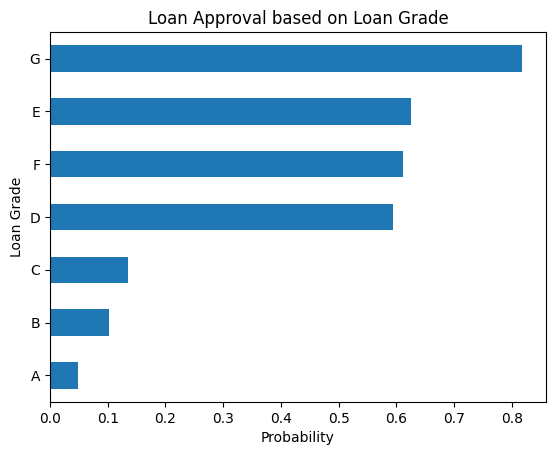

In [12]:
df.groupby(["loan_grade"])["loan_status"].mean().sort_values().plot(kind="barh")
plt.title("Loan Approval based on Loan Grade")
plt.ylabel("Loan Grade")
plt.xlabel("Probability");

Wow, this is giving us more insight into the data.

People in grade `A`, `B`, or `C` has less chance of getting loan.

## Splitting Data.

In [13]:
# Feature matrix.
target = "loan_status"
X = df.drop(columns=target)
# Target Vector.
y = df[target]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape

((46916, 11), (46916,))

## Baseline Model

In [15]:
print(f"Baseline Model: {round(y_train.value_counts(normalize=True).max(), 2)}")

Baseline Model: 0.86


## Model

In [16]:
lgbm = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    MinMaxScaler(),
    LGBMClassifier(random_state=42, verbose=-1)
)
lgbm.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['person_home_ownership', 'loan_intent',
                                     'loan_grade',
                                     'cb_person_default_on_file'],
                               use_cat_names=True)),
                ('minmaxscaler', MinMaxScaler()),
                ('lgbmclassifier',
                 LGBMClassifier(random_state=42, verbose=-1))])

In [17]:
y_test_pred= lgbm.predict(X_test)
roc_auc_score(y_test, y_test_pred)

0.8590490503629385

## Moment of Truth.

In [18]:
test_filepath = "/kaggle/input/playground-series-s4e10/test.csv"
df_test = wrangle(test_filepath)
test_pred = lgbm.predict_proba(df_test)[:, 1]
pd.DataFrame({"loan_status": test_pred}, index= df_test.index).to_csv("LGB.csv")